In [0]:
#if you are using it in spyder or anaconda use !pip install cv2 (Note: prefered to run over here only)
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
font = cv2.FONT_HERSHEY_COMPLEX
from google.colab.patches import cv2_imshow
from PIL import Image

# Step 1 - Identify bank notes in the image

In [0]:
#in left margin there is an upload option, upload image and then right_click and copy path.. paste the path below
#Change the path name here 
# path_name="/content/USD.png"
path_name = "/content/CAD.png"
# path_name = "/content/cad-10.jpg"
img2 = cv2.imread(path_name)
img2 = cv2.resize(img2, (300, 300))
img = cv2.imread(path_name, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (300, 300))

In [0]:
# Detect edges using Canny edge detector
edges = cv2.Canny(img2, 100, 40, L2gradient=True)
# _, threshold = cv2.threshold(img, 250, 255, cv2.THRESH_BINARY)
_, contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [0]:
#Drawing contours
# for cnt in contours:
#     approx = cv2.approxPolyDP(cnt, 0.01*cv2.arcLength(cnt, True), True)
#     cv2.drawContours(img, [approx], 0, (0), 1)
#     x = approx.ravel()[0]
#     y = approx.ravel()[1]

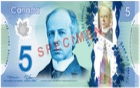

0


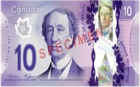

1


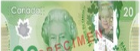

2


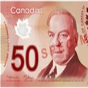

3


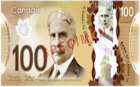

4


In [0]:
#For cropping, saving and giving boundary limits to currency
def rectanglesIntersection(coords1, size1, coords2, size2):
  x = max(coords1[0], coords2[0])
  y = max(coords1[1], coords2[1])
  w = min(coords1[0] + size1[0], coords2[0] + size2[0]) - x
  h = min(coords1[1]+ size1[1], coords2[1] + size2[1]) - y
  # print(w, h)
  if w <= 0 or h <= 0:
    return 0
  return w * h

def extract_segments(contours, min_width=80, min_height=50):
  segments = []
  for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    # threshold on the minimum size of the bank note.
    # since all images are resized to the same dimensions, should work fine.
    if (w > min_width and h > min_height):
      # out of intersecting contours take the one with the largest area
      area = h * w
      if len(segments) == 0:
        segments.append(((x, y), (w, h)))
      add_boundary = True
      for i, segment in enumerate(segments):
        old_area = segment[1][0] * segment[1][1]
        intersection = rectanglesIntersection((x, y), (w, h), segment[0], segment[1])
        if intersection > area * 0.1: # more than 10% intersects
          add_boundary = False
          if old_area < area:
            segments[i] = (x, y), (w, h)
      if add_boundary:
        segments.append(((x, y), (w, h)))
  return segments

def display_segments(original_img, segments):
  for i, segment in enumerate(segments):
    (x, y), (w, h) = segment
    new_img = original_img[y : y+h, x : x+w]
    # cv2.imwrite('/content/gdrive/My Drive/Colab Notebooks/Project/cad-extracted-{0}.png'.format(i), new_img)
    cv2_imshow(new_img)
    print(i)

bank_notes = extract_segments(contours)
display_segments(img2, bank_notes)

# Step 2 - Apply UNet and segment the bank note

In [0]:
# UNet Implementation
# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
  
import tensorflow as tf
import numpy as np 
import cv2 as cv
import glob
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.optimizers as optimizers
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

def diceCoef(mask, predicted_mask, smooth=10 ** (-7)):
    intersection = K.sum(K.abs(mask * predicted_mask), axis=[1,2,3])
    union = K.sum(K.abs(mask), axis=[1, 2, 3]) + K.sum(K.abs(predicted_mask), axis=[1, 2, 3])
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

class UNet:
    def __init__(self, loss="binary_crossentropy"):
        self.test_input = None
        self.train_input = None
        self.test_seg = None
        self.train_seg = None
        self.train_n = 0
        self.test_n = 0
        self.model = None
        self.loss = loss
    
    def buildModel(self):
        # contracting path
        inputs = keras.Input(shape=(128, 128, 1))
        conv64_1 = layers.Conv2D(64, 3, padding="same", activation="relu",
                                 kernel_initializer="he_normal")(inputs)
        conv64_2 = layers.Conv2D(64, 3, padding="same", activation="relu",
                                 kernel_initializer="he_normal")(conv64_1)
        dropout64 = layers.Dropout(0.2)(conv64_2)
        maxpool1 = layers.MaxPool2D(pool_size=(2, 2), strides=2,
                                    padding="same")(dropout64) # 64 x 64
        conv128_1 = layers.Conv2D(128, 3, padding="same", activation="relu",
                                  kernel_initializer="he_normal")(maxpool1)
        conv128_2 = layers.Conv2D(128, 3, padding="same", activation="relu",
                                  kernel_initializer="he_normal")(conv128_1)
        dropout128 = layers.Dropout(0.2)(conv128_2)
        maxpool2 = layers.MaxPool2D(pool_size=(2, 2), strides=2,
                                    padding="same")(dropout128) # 32 x 32
        conv256_1 = layers.Conv2D(256, 3, padding="same", activation="relu",
                                  kernel_initializer="he_normal")(maxpool2)
        conv256_2 = layers.Conv2D(256, 3, padding="same", activation="relu",
                                  kernel_initializer="he_normal")(conv256_1)
        dropout256 = layers.Dropout(0.2)(conv256_2)

        maxpool3 = layers.MaxPool2D(pool_size=(2, 2), strides=2,
                                    padding="same")(dropout256) # 16 x 16
        conv512_1 = layers.Conv2D(512, 3, padding="same", activation="relu",
                                  kernel_initializer="he_normal")(maxpool3)
        conv512_2 = layers.Conv2D(512, 3, padding="same", activation="relu",
                                  kernel_initializer="he_normal")(conv512_1)
        dropout512 = layers.Dropout(0.2)(conv512_2)
        # maxpool4 = layers.MaxPool2D(pool_size=(2, 2), strides=2,
        #                             padding="same")(dropout512) # 8 x 8
        # conv1024_1 = layers.Conv2D(1024, 3, padding="same", activation="relu",
        #                            kernel_initializer="he_normal")(maxpool4)
        # conv1024_2 = layers.Conv2D(1024, 3, padding="same", activation="relu",
        #                            kernel_initializer="he_normal")(conv1024_1)
        # dropout1024 = layers.Dropout(0.2)(conv1024_2)

        # expanding path
        # upsample1 = layers.UpSampling2D(size=(2, 2))(dropout1024) # 16 x 16
        # upconv1 = layers.Conv2DTranspose(512, 2, padding="same",
        #                                  activation="relu",
        #                                  kernel_initializer="he_normal")(upsample1)
        # concat1 = layers.Concatenate()([conv512_2, upconv1])

        # conv512up_1 = layers.Conv2DTranspose(512, 3, padding="same",
        #                                      activation="relu",
        #                                      kernel_initializer="he_normal")(concat1)
        # conv512up_2 = layers.Conv2DTranspose(512, 3, padding="same",
        #                                      activation="relu",
        #                                      kernel_initializer="he_normal")(conv512up_1)
        # dropout512up = layers.Dropout(0.2)(conv512up_2)
        upsample2 = layers.UpSampling2D(size=(2, 2))(dropout512) # 32 x 32
        upconv2 = layers.Conv2DTranspose(256, 2, padding="same",
                                         activation="relu",
                                         kernel_initializer="he_normal")(upsample2)
        concat2 = layers.Concatenate()([conv256_2, upconv2])
        conv256up_1 = layers.Conv2DTranspose(128, 3, padding="same",
                                             activation="relu",
                                             kernel_initializer="he_normal")(concat2)
        conv256up_2 = layers.Conv2DTranspose(128, 3, padding="same",
                                             activation="relu",
                                             kernel_initializer="he_normal")(conv256up_1)
        dropout256up = layers.Dropout(0.2)(conv256up_2)

        upsample3 = layers.UpSampling2D(size=(2, 2))(dropout256up) # 64 x 64
        upconv3 = layers.Conv2DTranspose(128, 2, padding="same",
                                         activation="relu",
                                         kernel_initializer="he_normal")(upsample3)
        concat3 = layers.Concatenate()([conv128_2, upconv3])
        conv128up_1 = layers.Conv2DTranspose(128, 3, padding="same",
                                             activation="relu",
                                             kernel_initializer="he_normal")(concat3)
        conv128up_2 = layers.Conv2DTranspose(128, 3, padding="same",
                                             activation="relu",
                                             kernel_initializer="he_normal")(conv128up_1)
        dropout128up = layers.Dropout(0.2)(conv128up_2)
        upsample4 = layers.UpSampling2D(size=(2, 2))(dropout128up) # 128 x 128
        upconv4 = layers.Conv2DTranspose(64, 2, padding="same",
                                         activation="relu",
                                         kernel_initializer="he_normal")(upsample4)
        concat4 = layers.Concatenate()([conv64_2, upconv4])
        conv64up_1 = layers.Conv2DTranspose(64, 3, padding="same",
                                            activation="relu",
                                            kernel_initializer="he_normal")(concat4)
        conv64up_2 = layers.Conv2DTranspose(64, 3, padding="same",
                                            activation="relu",
                                            kernel_initializer="he_normal")(conv64up_1)
        dropout64up = layers.Dropout(0.2)(conv64up_2)
        conv64up_3 = layers.Conv2DTranspose(2, 3, padding="same",
                                            kernel_initializer="he_normal")(dropout64up)
        
        outputs = layers.Conv2DTranspose(
            filters=1,
            kernel_size=1,
            padding="same",
            activation="sigmoid",
            kernel_initializer="he_normal"
       )(conv64up_3)


        self.model = keras.Model(inputs=inputs, outputs=outputs)
        
        self.model.compile(optimizer=optimizers.Adam(),
              loss=self.loss,
              metrics=['accuracy', diceCoef])
        print("UNet model is complete")

    def train(self, epochs, batch_size=10):
        print("Starting training...")
        self.model.fit(
            self.train_input,
            self.train_seg,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.15)

    
    def evaluate(self):
        print("Evaluating segmentation model...")
        self.model.evaluate(self.test_input, self.test_seg, verbose=2)

    def predict(self, imgs):
        predictions = self.model.predict(imgs)
        return predictions
    
    def saveWeights(self, name):
        self.model.save_weights(name)
    
    def loadWeights(self, name):
        self.model.load_weights(name)
    
    def plotPrediction(self, prediction, truth, img):
        fig = plt.figure(figsize=(10, 10))
        fig.add_subplot(1, 3, 1)
        plt.imshow(prediction[...,0], cmap="gray")
        fig.add_subplot(1, 3, 2)
        plt.imshow(truth[..., 0], cmap="gray")

        fig.add_subplot(1, 3, 3)
        plt.imshow(img[..., 0], cmap="gray")

        plt.show()

    def loadData(self, trainInputDirPath, trainSegDirPath, testInputDirPath, testSegDirPath, trainAugInput=None, trainAugSeg=None):
        self.train_input = self.__loadDataFromDir(trainInputDirPath)
        self.test_input = self.__loadDataFromDir(testInputDirPath)
        self.train_seg = self.__loadDataFromDir(trainSegDirPath)
        self.test_seg = self.__loadDataFromDir(testSegDirPath)
        if trainAugInput and trainAugSeg:
            self.train_input = np.vstack((self.train_input, self.__loadDataFromDir(trainAugInput)))
            self.train_seg = np.vstack((self.train_seg, self.__loadDataFromDir(trainAugSeg)))
        self.train_n = self.train_input.shape[0]
        self.test_n = self.test_input.shape[0]

        print("Data is loaded:")
        print("Number of training images: {0}".format(self.train_n))
        print("Number of testing images: {0}".format(self.test_n))
        print("Training input set shape: {0}".format(self.train_input.shape))
        print("Training segmentation set shape: {0}".format(self.train_seg.shape))
        print("Testing input set shape: {0}".format(self.test_input.shape))
        print("Testing segmentation set shape: {0}".format(self.test_seg.shape))
    
    def __loadDataFromDir(self, dirPath):
        imgs = []
        for i, imgName in enumerate(sorted(glob.glob(dirPath + "/*"))):
            if i % 1000 == 0:
              print("Loaded {0} images from {1}".format(i, dirPath))
            img = cv.imread(imgName)
            img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
            img = cv.resize(img, (128, 128)) / 255.0
            img = np.expand_dims(img, axis=2).astype(np.float32)
            imgs.append(img)
        
        imgsMatrix = np.array(imgs)
        return imgsMatrix

TensorFlow 2.x selected.


In [0]:
# Upload the oxford_data-20191107T212728Z-001.zip to /content/
!unzip "/content/oxford_data-20191107T212728Z-001.zip" 

Archive:  /content/oxford_data-20191107T212728Z-001.zip
  inflating: oxford_data/Test/output/mask-986.jpg  
  inflating: oxford_data/Test/output/mask-977.jpg  
  inflating: oxford_data/Test/output/mask-999.jpg  
  inflating: oxford_data/Test/output/mask-997.jpg  
  inflating: oxford_data/Test/output/mask-998.jpg  
  inflating: oxford_data/Test/output/mask-990.jpg  
  inflating: oxford_data/Test/output/mask-981.jpg  
  inflating: oxford_data/Test/output/mask-99.jpg  
  inflating: oxford_data/Test/output/mask-985.jpg  
  inflating: oxford_data/Test/output/mask-992.jpg  
  inflating: oxford_data/Test/output/mask-991.jpg  
  inflating: oxford_data/Test/output/mask-993.jpg  
  inflating: oxford_data/Test/output/mask-995.jpg  
  inflating: oxford_data/Test/output/mask-987.jpg  
  inflating: oxford_data/Test/output/mask-996.jpg  
  inflating: oxford_data/Test/output/mask-984.jpg  
  inflating: oxford_data/Test/output/mask-982.jpg  
  inflating: oxford_data/Test/output/mask-98.jpg  
  inflatin

In [0]:
# Build model and train
transferUnet = UNet(loss="binary_crossentropy")
transferUnet.buildModel()
transferUnet.loadData(
        "./oxford_data/Train/input",
        "./oxford_data/Train/output",
        "./oxford_data/Test/input",
        "./oxford_data/Test/output")
total_epochs = 0

UNet model is complete
Loaded 0 images from ./oxford_data/Train/input
Loaded 1000 images from ./oxford_data/Train/input
Loaded 2000 images from ./oxford_data/Train/input
Loaded 3000 images from ./oxford_data/Train/input
Loaded 4000 images from ./oxford_data/Train/input
Loaded 5000 images from ./oxford_data/Train/input
Loaded 0 images from ./oxford_data/Test/input
Loaded 1000 images from ./oxford_data/Test/input
Loaded 2000 images from ./oxford_data/Test/input
Loaded 0 images from ./oxford_data/Train/output
Loaded 1000 images from ./oxford_data/Train/output
Loaded 2000 images from ./oxford_data/Train/output
Loaded 3000 images from ./oxford_data/Train/output
Loaded 4000 images from ./oxford_data/Train/output
Loaded 5000 images from ./oxford_data/Train/output
Loaded 0 images from ./oxford_data/Test/output
Loaded 1000 images from ./oxford_data/Test/output
Loaded 2000 images from ./oxford_data/Test/output
Data is loaded:
Number of training images: 5169
Number of testing images: 2439
Trainin

In [0]:
epochs = 5
total_epochs += epochs
transferUnet.train(epochs, 32)
transferUnet.evaluate()

Starting training...
Train on 4393 samples, validate on 776 samples
Epoch 1/5
4393/4393 [==============================] - 39s 9ms/sample - loss: 1.7946 - accuracy: 0.6464 - diceCoef: 0.5243 - val_loss: 0.4797 - val_accuracy: 0.7067 - val_diceCoef: 0.5541
Epoch 2/5
4393/4393 [==============================] - 31s 7ms/sample - loss: 0.4473 - accuracy: 0.7283 - diceCoef: 0.6290 - val_loss: 0.4712 - val_accuracy: 0.7136 - val_diceCoef: 0.5757
Epoch 3/5
4393/4393 [==============================] - 31s 7ms/sample - loss: 0.3982 - accuracy: 0.7502 - diceCoef: 0.6717 - val_loss: 0.4334 - val_accuracy: 0.7345 - val_diceCoef: 0.6009
Epoch 4/5
4393/4393 [==============================] - 31s 7ms/sample - loss: 0.3608 - accuracy: 0.7657 - diceCoef: 0.7019 - val_loss: 0.3849 - val_accuracy: 0.7545 - val_diceCoef: 0.6402
Epoch 5/5
4393/4393 [==============================] - 31s 7ms/sample - loss: 0.3312 - accuracy: 0.7783 - diceCoef: 0.7263 - val_loss: 0.3375 - val_accuracy: 0.7777 - val_diceCoef:

In [0]:
# transferUnet.saveWeights("/content/oxford_unet_epochs_{0}.h5".format(total_epochs))

In [0]:
def plotTestPrediction(unet, i=0):
    img = unet.test_input[i]
    predictions = unet.predict(np.array([img]))
    unet.plotPrediction(predictions[0], unet.test_seg[i], unet.test_input[i])

def plotTrainPrediction(unet, i=0):
    img = unet.train_input[i]
    predictions = unet.predict(np.array([img]))
    print(crossEntropy(predictions, np.array([unet.train_seg[i]])))
    unet.plotPrediction(predictions[0], unet.train_seg[i], unet.train_input[i])

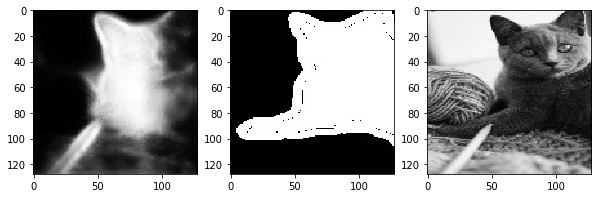

In [0]:
plotTestPrediction(transferUnet, 0)

In [0]:
# Upload the currency_data-20191107T220734Z-001.zip to /content/
!unzip "/content/currency_data-20191107T220734Z-001.zip" 

Archive:  /content/currency_data-20191107T220734Z-001.zip
  inflating: currency_data/inputs/cad-10-2.png  
  inflating: currency_data/inputs/cad-4.png  
  inflating: currency_data/inputs/cad-5.png  
  inflating: currency_data/inputs/cad-2.png  
  inflating: currency_data/masks/mask-10-2.png  
  inflating: currency_data/inputs/cad-3.png  
  inflating: currency_data/masks/mask-2.png  
  inflating: currency_data/inputs/cad-1.png  
  inflating: currency_data/masks/mask-5.png  
  inflating: currency_data/masks/mask-4.png  
  inflating: currency_data/masks/mask-3.png  
  inflating: currency_data/masks/mask-1.png  


In [0]:
# Transfer learning from oxford_dataset segmentation to currency data
currencyUnet = UNet(loss="binary_crossentropy")
currencyUnet.loadData(
        "./currency_data/inputs",
        "./currency_data/masks",
        "./currency_data/inputs",
        "./currency_data/masks")
currencyUnet.buildModel()
currencyUnet.loadWeights("/content/oxford_unet_epochs_35.h5")

Loaded 0 images from ./currency_data/inputs
Loaded 0 images from ./currency_data/inputs
Loaded 0 images from ./currency_data/masks
Loaded 0 images from ./currency_data/masks
Data is loaded:
Number of training images: 6
Number of testing images: 6
Training input set shape: (6, 128, 128, 1)
Training segmentation set shape: (6, 128, 128, 1)
Testing input set shape: (6, 128, 128, 1)
Testing segmentation set shape: (6, 128, 128, 1)
UNet model is complete


In [0]:
currencyUnet.train(10, 1)
currencyUnet.evaluate()

Starting training...
Train on 5 samples, validate on 1 samples
Epoch 1/10
5/5 [==============================] - 3s 503ms/sample - loss: 0.6920 - accuracy: 0.6785 - diceCoef: 0.4793 - val_loss: 0.5263 - val_accuracy: 0.6579 - val_diceCoef: 0.3988
Epoch 2/10
5/5 [==============================] - 0s 20ms/sample - loss: 0.4528 - accuracy: 0.7526 - diceCoef: 0.4832 - val_loss: 0.5072 - val_accuracy: 0.7413 - val_diceCoef: 0.5060
Epoch 3/10
5/5 [==============================] - 0s 19ms/sample - loss: 0.3398 - accuracy: 0.8274 - diceCoef: 0.6502 - val_loss: 0.3717 - val_accuracy: 0.8334 - val_diceCoef: 0.6694
Epoch 4/10
5/5 [==============================] - 0s 19ms/sample - loss: 0.2396 - accuracy: 0.8742 - diceCoef: 0.7798 - val_loss: 0.2800 - val_accuracy: 0.8538 - val_diceCoef: 0.7324
Epoch 5/10
5/5 [==============================] - 0s 19ms/sample - loss: 0.1741 - accuracy: 0.9029 - diceCoef: 0.8345 - val_loss: 0.2267 - val_accuracy: 0.8724 - val_diceCoef: 0.7703
Epoch 6/10
5/5 [=====

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  import sys


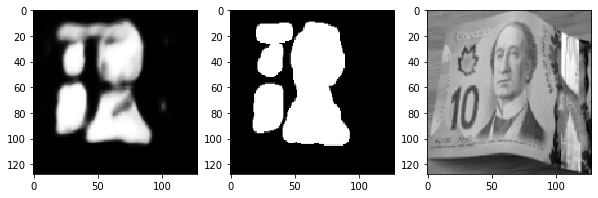

In [0]:
test_example = cv2.imread("/content/cad-extracted-0.png")
test_example = cv2.cvtColor(test_example, cv.COLOR_RGB2GRAY)
test_example = np.expand_dims(cv2.resize(test_example, (128, 128)) / 255.0, 2)

test_mask = cv2.imread("/content/mask-extracted-0.png")
test_mask = cv2.cvtColor(test_mask, cv.COLOR_RGB2GRAY)
test_mask = np.expand_dims(cv2.resize(test_mask, (128, 128)) / 255.0, 3)

tests = np.array([test_example])
predictions = currencyUnet.predict(tests)
currencyUnet.plotPrediction(predictions[0], test_mask, test_example)

# Step 3 - Extract denomination, flag and special design to help determine the value and type of currency

**Problem:** Currently, the various region of interest isn't extracted clearly.

**To Do:** 
- Ultimately we need to find a way to extract the value (denomination) and the flag (example: Canadian Maple Leaf Flag) and anything else that helps determine the type of currency (example: the head of the figure on the note)
- Also, need to determine the value of the note as well as the type of the currency
  - Can use another neural net or template matching
  - Or can use the algorithm from https://www.researchgate.net/publication/323056402_Currency_recognition_system_using_image_processing
  - Or open to suggestion

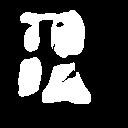

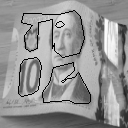

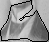

0


1


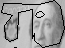

2


In [0]:
predicted_mask = (predictions[0][...,0] * 255).astype(np.uint8)
_, thresholded = cv2.threshold(predicted_mask, 127, 255, cv2.THRESH_BINARY)
cv2_imshow(thresholded)
_, contours_bill, _ = cv2.findContours(thresholded, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

original = test_example[..., 0] * 255
for cnt in contours_bill:
    approx = cv2.approxPolyDP(cnt, 0.01*cv2.arcLength(cnt, True), True)
    cv2.drawContours(original, [approx], 0, (0), 1)
    x = approx.ravel()[0]
    y = approx.ravel()[1]
cv2_imshow(original)
areas = extract_segments(contours_bill, 1, 1)
display_segments(original, areas)